In [360]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from helper_functions import utils
import pickle as pkl
utils.default_plot_format()
utils.pd_display_settings(3)
import os

In [ ]:
data_path = "processed_data/stamped_Metrics_2025_02_27.pkl"

pickled = pd.read_pickle(data_path)
data = pickled["data"]
indicator_columns = pickled["indicator_columns"]
time_metrics = pickled["time_metrics"]
frequency_metrics = pickled["frequency_metrics"]
non_linear_metrics = pickled["non_linear_metrics"]

data.head()

,t_start,t_end,SDRR,RMSSD,pNN50 (%),Mean HR (bpm),ULF Power,ULF Peak Frequency,VLF Power,VLF Peak Frequency,...,UCr (g),UACR (mg÷g),Complications,Nephropathy,Retinopathy and cataract,DPN,Heart Disease,atherosclerosis or stenosis,Carotid Plaque,Condition
0,0,300,60.93,61.35,4.42,81.42,0,0,3.71,0.0267,...,NaN,NaN,0,0,0,False,0,0,0,Diabetes
1,300,600,58.91,36.23,3.90,82.09,0,0,1.84,0.03,...,NaN,NaN,0,0,0,False,0,0,0,Diabetes
2,600,900,91.85,71.25,12.10,74.51,0,0,7.00,0.0234,...,NaN,NaN,0,0,0,False,0,0,0,Diabetes
3,900,1200,93.23,90.24,13.39,73.35,0,0,2.37,0.02,...,NaN,NaN,0,0,0,False,0,0,0,Diabetes
4,1200,1500,51.21,33.28,10.95,69.57,0,0,4.53,0.0368,...,NaN,NaN,0,0,0,False,0,0,0,Diabetes


In [378]:
print("time_metrics =", time_metrics)
print("frequency_metrics =", frequency_metrics)
print("non_linear_metrics =", non_linear_metrics)

time_metrics = ['SDRR', 'RMSSD', 'pNN50 (%)', 'Mean HR (bpm)']
frequency_metrics = ['VLF Power', 'LF Power', 'HF Power', 'LF÷HF Ratio']
non_linear_metrics = ['S', 'SD1', 'SD2', 'SD1÷SD2', 'ApEn', 'SampEn', 'DFA α1', 'DFA α2', 'D2']


Loose the upper decile of HR since it is activity polluted data.

In [363]:
from project_utils import deciles

data = deciles.make_decile_column(data, "Mean HR (bpm)")
data[data["Mean HR (bpm)_decile"]!=9].tail()

,t_start,t_end,SDRR,RMSSD,pNN50 (%),Mean HR (bpm),ULF Power,ULF Peak Frequency,VLF Power,VLF Peak Frequency,...,UACR (mg÷g),Complications,Nephropathy,Retinopathy and cataract,DPN,Heart Disease,atherosclerosis or stenosis,Carotid Plaque,Condition,Mean HR (bpm)_decile
10627,33000,33300,209.85,245.17,31.87,72.91,0,0,57.96,0.0267,...,0.43,1,0,0,True,0,0,1,DPN,0
10628,33300,33600,150.95,205.07,8.67,73.94,0,0,56.90,0.0367,...,0.43,1,0,0,True,0,0,1,DPN,0
10629,33600,33900,113.52,130.00,9.02,75.48,0,0,7.26,0.0367,...,0.43,1,0,0,True,0,0,1,DPN,0
10630,33900,34200,63.54,76.52,3.42,76.19,0,0,1.00,0.0267,...,0.43,1,0,0,True,0,0,1,DPN,0
10631,34200,34500,166.76,198.15,13.48,74.25,0,0,8.14,0.0367,...,0.43,1,0,0,True,0,0,1,DPN,0


# Resample mean for each condition repeatedly


In [364]:
control_id = data[~data['DPN']].id.unique()
dpn_id = data[data['DPN']].id.unique()

print(control_id, dpn_id)

['19070921' '19072205' '19072214' '19072938' '19072939' '19072940'
 '19080106' '19081506' '19082406' '19090308' '19090320' '19102102'
 '19102524' '19112609' '19121303' '19121735' '20050628' '20052606'
 '20061729' '20120922' '20121033' '20121718'] ['19101619' '20010826' '20101822' '20123017']


## Reusable resample function

In [365]:
import numpy as np
class PatientBootstrap():
    """Bootstraps a distribution of a metric for a group of ids.
    Bootstraps mean by repeatedly sampling 1 datum from each patient id;
    then a mean for DPN and control groups is calculated.
    Args:
        data (pd.DataFrame): The data to sample from
        n (int): Number of means to sample
        save_folder (str): Folder to save the memory of the bootstrapper
    """

    def __init__(self, data, n=5000, save_folder = "processed_data/bayesian_bootstrap"):
        self.data = data
        self.n = n
        self.memory = {}

        self.save_folder = save_folder
        if not os.path.exists(self.save_folder):
            os.makedirs(self.save_folder)

    def sample_metric(self, metric:str, id:str):
        """Sample a single value of a metric for a given id"""
        return self.data.loc[self.data['id'] == id, metric].sample(1).values[0]

    def sample_group_metric(self, metric:str, ids:list[str]):
        """Sample a single value of a metric for each id"""
        return [self.sample_metric(metric, ID) for ID in ids]

    def get_distribution(self, metric:str, ids:str, agg_func=np.mean):
        """Get a distribution of a metric for a group of ids"""
        values = [self.sample_group_metric(metric, ids) for _ in range(self.n)]
        distribution = [agg_func(group) for group in values]
        return distribution
    
    def sample_dpn_control(self, metric:str, dpn_id:list, control_id:list, agg_func=np.mean):
        """RENAME, get the distribution of a metric for both DPN and control group"""
        self.memory[metric] ={'DPN': self.get_distribution(metric, dpn_id),
                                'Control':self.get_distribution(metric, control_id, agg_func=np.mean)}
        return self.memory[metric]
    
    def access_memory_metric(self, metric:str):
        return self.memory[metric]
    
    def pickle_memory(self, file_name:str="sampler_memory.pkl"):
        path = os.path.join(self.save_folder,file_name)
        with open(path, 'wb') as f:
            pkl.dump(self.memory, f)

    def load_memory(self, file_name:str="sampler_memory.pkl"):
        path = os.path.join(self.save_folder,file_name)
        with open(path, 'rb') as f:
            self.memory = pkl.load(f)

bootstrap each metric for control and dnp separately.

The data is pickled, since looking at each metric with n=5000 takes about 30 min

In [366]:
sampler = PatientBootstrap(data)
file_name="HR_decile_Bayes.pkl"
try:
    sampler.load_memory()
except FileNotFoundError:
    for metric in indicator_columns:
        sampler.sample_dpn_control(metric, dpn_id=dpn_id, control_id=control_id)
    sampler.pickle_memory(file_name)

In [367]:
def calculate_metric(control, dpn, metric):
    bayes_p = np.mean(pd.Series(control) < pd.Series(dpn))
    results = {
        'Metric': metric,
        'Bayes_p': bayes_p if bayes_p < 0.5 else 1 - bayes_p,
        'DPN_Mean': np.mean(dpn),
        'DPN_Std': np.std(dpn),
        'Control_Mean': np.mean(control),
        'Control_Std': np.std(control)
    }
    results_df = pd.DataFrame([results])
    return results_df

def draw_metric(control, dpn, metric):
    plt.figure(figsize=(8, 4))
    plt.hist(control, bins=50, density=True, alpha=0.5, color='blue')
    plt.hist(dpn, bins=50, density=True, alpha=0.5, color='red')
    plt.title(f'Density Plot of {metric} Distribution for Control Group')
    plt.xlabel(metric)
    plt.show()



,Metric,Bayes_p,DPN_Mean,DPN_Std,Control_Mean,Control_Std
0,SDRR,0.18,56.73,25.25,83.36,10.70


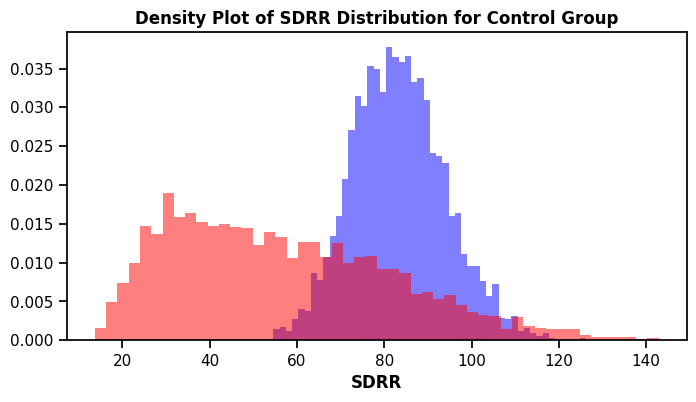

,Metric,Bayes_p,DPN_Mean,DPN_Std,Control_Mean,Control_Std
0,RMSSD,0.21,55.96,30.95,82.26,13.82


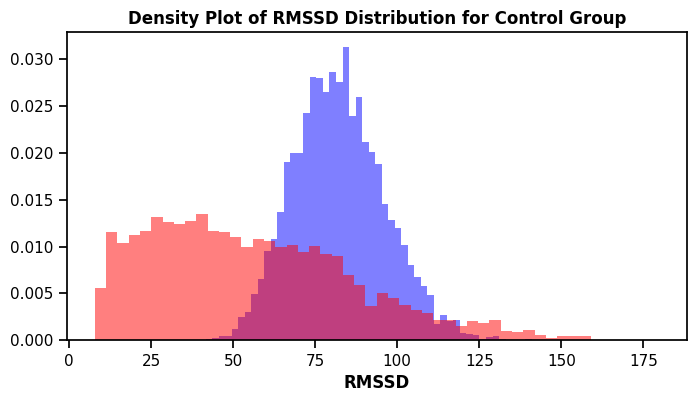

,Metric,Bayes_p,DPN_Mean,DPN_Std,Control_Mean,Control_Std
0,pNN50 (%),0.12,6.26,5.39,14.21,3.14


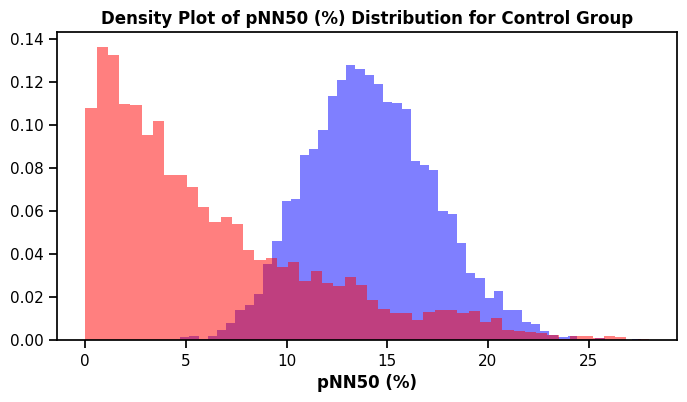

,Metric,Bayes_p,DPN_Mean,DPN_Std,Control_Mean,Control_Std
0,Mean HR (bpm),0.066,83.60,4.92,75.36,2.06


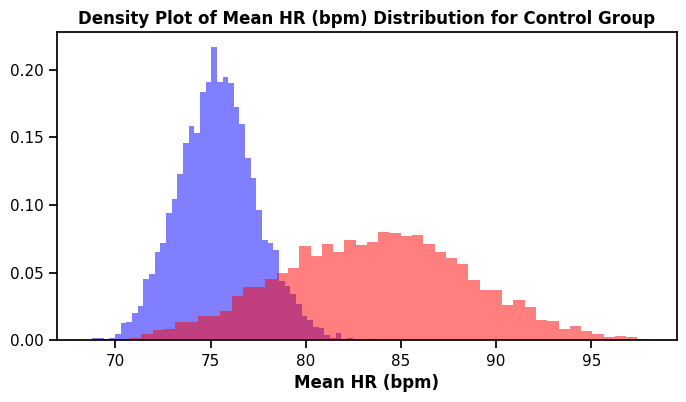

In [368]:
for metric in time_metrics:
    dpn, control = sampler.memory[metric]['DPN'], sampler.memory[metric]['Control']
    display(calculate_metric(control, dpn, metric))
    draw_metric(control, dpn, metric)

,Metric,Bayes_p,DPN_Mean,DPN_Std,Control_Mean,Control_Std
0,VLF Power,0.20,3.77,5.46,6.06,2.13


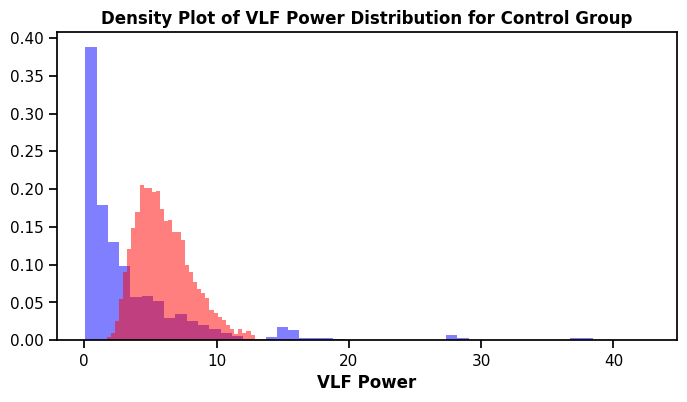

,Metric,Bayes_p,DPN_Mean,DPN_Std,Control_Mean,Control_Std
0,LF Power,0.28,104.30,126.58,146.30,60.15


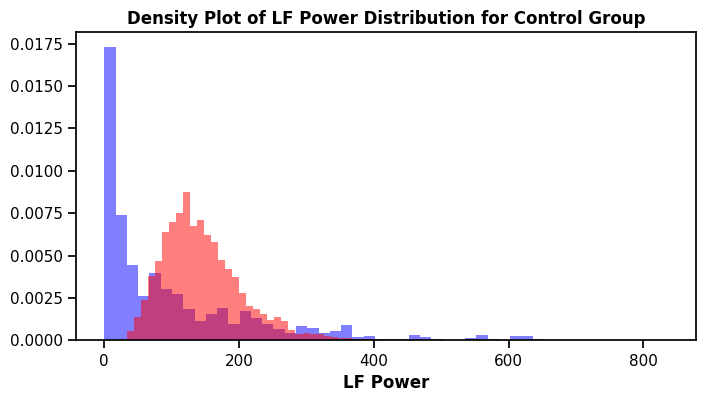

,Metric,Bayes_p,DPN_Mean,DPN_Std,Control_Mean,Control_Std
0,HF Power,0.31,1629,1855,2229,903.50


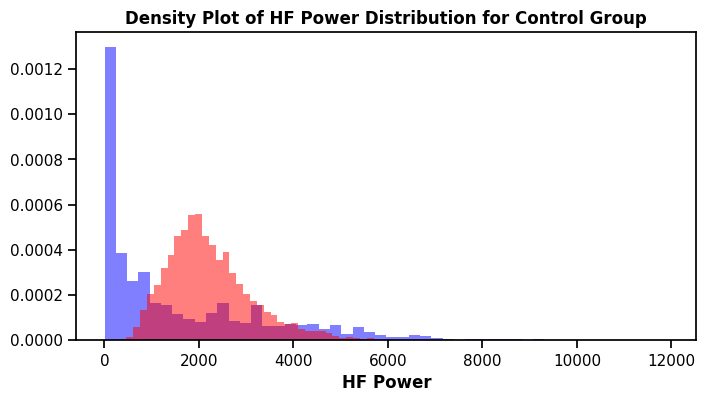

,Metric,Bayes_p,DPN_Mean,DPN_Std,Control_Mean,Control_Std
0,LF÷HF Ratio,0.38,0.13,0.0585,0.14,0.0314


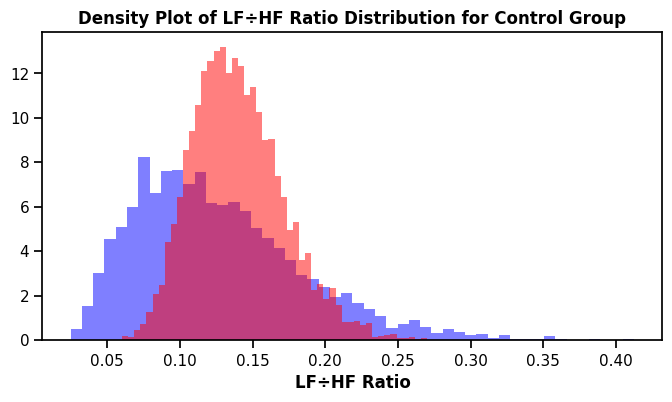

In [369]:
for metric in frequency_metrics:
    dpn, control = sampler.memory[metric]['DPN'], sampler.memory[metric]['Control']
    display(calculate_metric(control, dpn, metric))
    draw_metric(dpn, control, metric)

,Metric,Bayes_p,DPN_Mean,DPN_Std,Control_Mean,Control_Std
0,S,0.28,19641,18451,28820,8780


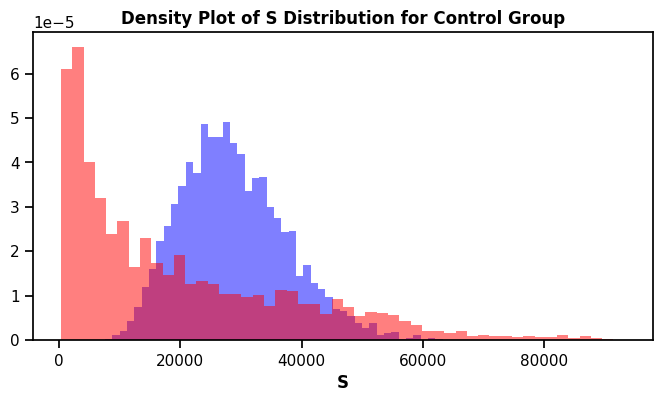

,Metric,Bayes_p,DPN_Mean,DPN_Std,Control_Mean,Control_Std
0,SD1,0.21,39.01,21.67,57.87,9.53


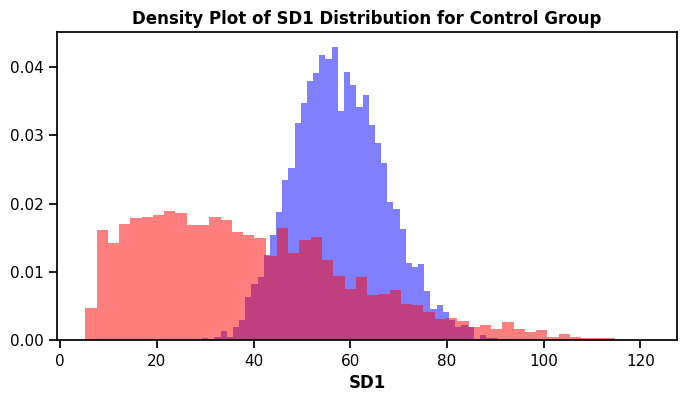

,Metric,Bayes_p,DPN_Mean,DPN_Std,Control_Mean,Control_Std
0,SD2,0.18,69.79,29.11,100.39,12.37


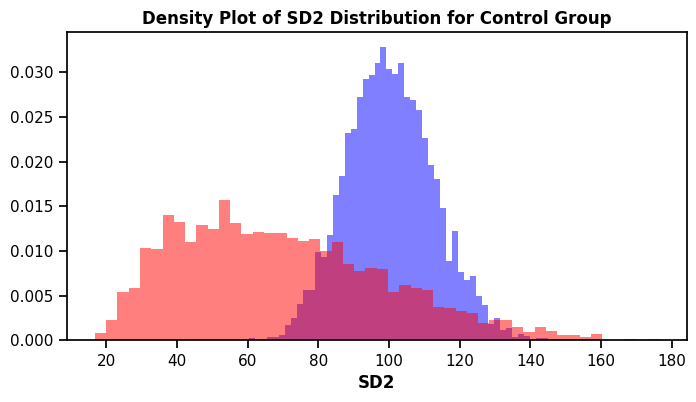

,Metric,Bayes_p,DPN_Mean,DPN_Std,Control_Mean,Control_Std
0,SD1÷SD2,0.32,0.48,0.11,0.53,0.0449


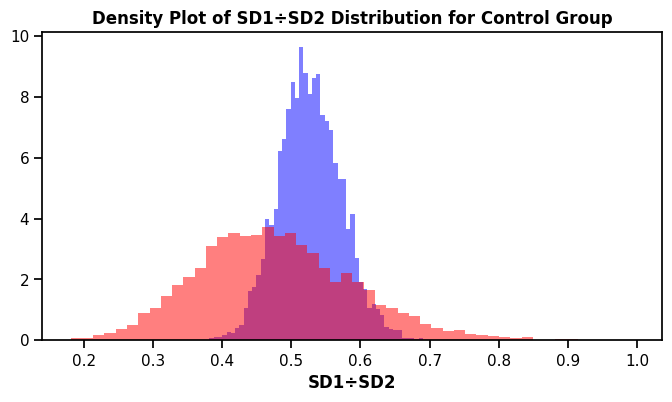

,Metric,Bayes_p,DPN_Mean,DPN_Std,Control_Mean,Control_Std
0,ApEn,0.45,0.86,0.13,0.88,0.0449


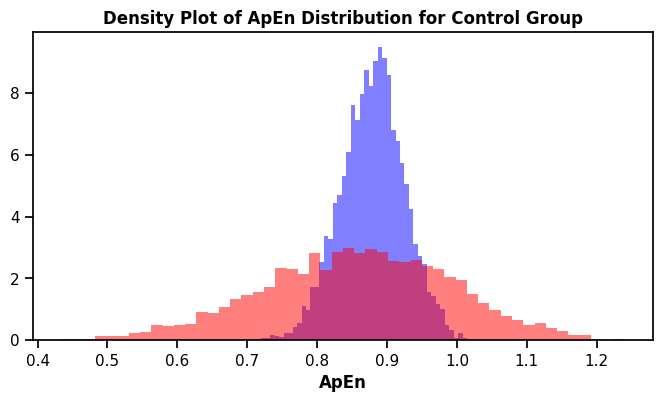

,Metric,Bayes_p,DPN_Mean,DPN_Std,Control_Mean,Control_Std
0,SampEn,0.49,1.04,0.26,1.02,0.0896


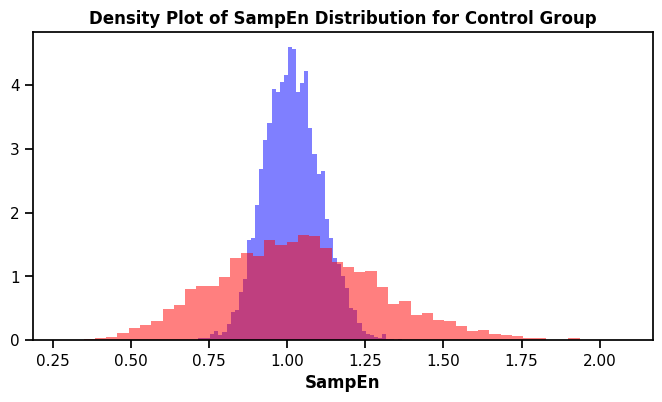

,Metric,Bayes_p,DPN_Mean,DPN_Std,Control_Mean,Control_Std
0,DFA α1,0.50,0.94,0.14,0.94,0.0541


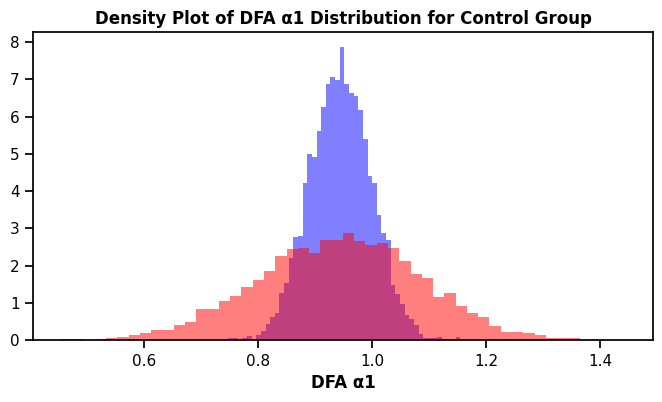

,Metric,Bayes_p,DPN_Mean,DPN_Std,Control_Mean,Control_Std
0,DFA α2,0.25,0.97,0.13,0.88,0.0472


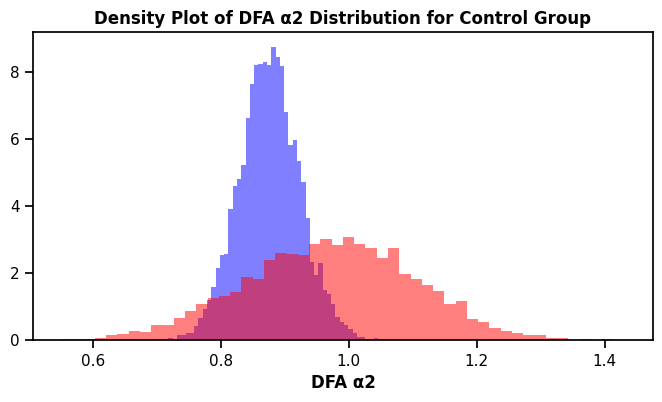

,Metric,Bayes_p,DPN_Mean,DPN_Std,Control_Mean,Control_Std
0,D2,0.0978,-3.03,12.54,-2.50,0.23


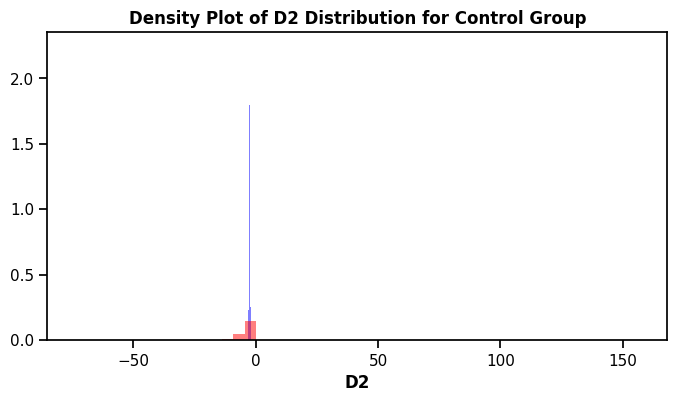

In [370]:
for metric in non_linear_metrics:
    dpn, control = sampler.memory[metric]['DPN'], sampler.memory[metric]['Control']
    display(calculate_metric(control, dpn, metric))
    draw_metric(control, dpn, metric)

# Dumb classifier approach

this has yielded no good results

I have an idea that checking how suitable each value is for each population would allow me to classify the data

In [371]:
bayes_table = pd.DataFrame()
for metric in indicator_columns:
    dpn, control = sampler.memory[metric]['DPN'], sampler.memory[metric]['Control']
    res = calculate_metric(control, dpn, metric)
    bayes_table = pd.concat ([bayes_table, res])

display(bayes_table)


,Metric,Bayes_p,DPN_Mean,DPN_Std,Control_Mean,Control_Std
0,SDRR,0.18,56.73,25.25,83.36,10.70
0,RMSSD,0.21,55.96,30.95,82.26,13.82
0,pNN50 (%),0.12,6.26,5.39,14.21,3.14
0,Mean HR (bpm),0.066,83.60,4.92,75.36,2.06
0,VLF Power,0.20,3.77,5.46,6.06,2.13
0,VLF Peak Frequency,0.36,0.0276,0.004,0.0293,0.00146
0,LF Power,0.28,104.30,126.58,146.30,60.15
0,LF Peak Frequency,0.36,0.0986,0.0168,0.11,0.00651
0,HF Power,0.31,1629,1855,2229,903.50
0,HF Peak Frequency,0.25,0.34,0.024,0.32,0.0115


Construct a model that could tell how likely is each value to belong to one of the two pupulations.

Fit a gaussian model onto of each distribution.

In [372]:
from scipy.stats import norm

gaussian_dpn = {}
gaussian_controls ={}

for row in bayes_table.iterrows():
    metric = row[1]['Metric']

    dpn_mean = row[1]['DPN_Mean']
    dpn_std = row[1]['DPN_Std']
    gaussian_dpn[metric] = norm(dpn_mean, dpn_std)

    control_mean = row[1]['Control_Mean']
    control_std = row[1]['Control_Std']
    gaussian_controls[metric] = norm(control_mean, control_std)

#density = norm.pdf(x, loc=mean, scale=std)
#print("PDF at x:", density)


calculate the chances of each value belonging to the distribution

In [373]:
chances = pd.DataFrame()
for row in data.iterrows():
  
    chance_dpn = {"x_"+metric: gaussian_dpn[metric].pdf(row[1][metric]) for metric in indicator_columns}

    chance_control = {"c_"+metric: gaussian_controls[metric].pdf(row[1][metric]) for metric in indicator_columns}
    
    chance_dpn = pd.Series(chance_dpn)
    chance_control = pd.Series(chance_control)

    result = {
        'DPN': row[1]['DPN'],
        'DPN_chance': chance_dpn.prod(),
        'control_chance': chance_control.prod(),
        **chance_dpn,
        **chance_control
    }


    chances = pd.concat([chances, pd.DataFrame([result])], ignore_index=True)
    
chances.describe()

,DPN_chance,control_chance,x_SDRR,x_RMSSD,x_pNN50 (%),x_Mean HR (bpm),x_VLF Power,x_VLF Peak Frequency,x_LF Power,x_LF Peak Frequency,...,c_LF÷HF Ratio,c_S,c_SD1,c_SD2,c_SD1÷SD2,c_ApEn,c_SampEn,c_DFA α1,c_DFA α2,c_D2
count,6322,6322,6322,6322,6322,6322,6322,6322,6322,6322,...,6322,6322,6322,6322,6322,6322,6322,6322,6322,6322
mean,1.39e-20,6.53e-19,0.00773,0.0062,0.0383,0.0247,0.0561,40.24,0.00219,7.62,...,2.57,7.37e-06,0.00599,0.00469,1.33,1.18,0.75,1.22,1.32,0.40
std,2.15e-19,5.19e-17,0.00559,0.00432,0.0248,0.0283,0.0206,34.35,0.00088,8.02,...,3.87,1.28e-05,0.0118,0.00919,2.53,2.43,1.35,2.19,2.49,0.58
min,0,0,1.27e-55,2.85e-43,2.21e-63,5.63e-16,1.15e-155,1.09e-06,0,0.0531,...,0,0,5.47e-191,0,3.44e-138,1.02e-58,3.45e-76,2.44e-87,2.87e-97,0
25%,2.74e-38,1.7e-147,0.00236,0.00315,0.0139,0.000392,0.0584,7.42,0.00225,0.67,...,0.03,2.72e-07,3.17e-08,1.6e-09,4.29e-09,2.7e-09,2.4e-09,5.84e-08,3.43e-10,0.000117
50%,2.53e-29,9.64e-98,0.00784,0.00588,0.0402,0.01,0.0622,34.79,0.00235,3.96,...,0.46,7.04e-07,1.01e-05,8.07e-06,0.00173,0.00041,0.00102,0.00683,0.00142,0.0477
75%,4.64e-25,2.25e-67,0.013,0.0101,0.0583,0.0481,0.0685,82.14,0.00269,13.21,...,3.54,7.19e-06,0.00414,0.00312,1.18,0.56,0.79,1.25,1.08,0.70
max,9.73e-18,4.13e-15,0.0158,0.0129,0.074,0.081,0.0731,97.58,0.00315,23.71,...,12.69,4.54e-05,0.0418,0.0322,8.89,8.88,4.45,7.37,8.45,1.71


In [374]:
chances["shows_dpn"] = chances["DPN_chance"] > chances["control_chance"]

chances["true_positive"] = chances["shows_dpn"] & chances["DPN"]
chances["false_positive"] = chances["shows_dpn"] & ~chances["DPN"]
chances["true_negative"] = ~chances["shows_dpn"] & ~chances["DPN"]
chances["false_negative"] = ~chances["shows_dpn"] & chances["DPN"]


results = {
    "true_positive": chances["true_positive"].mean(),
    "true_negative": chances["true_negative"].mean(),
    "false_positive": chances["false_positive"].mean(),
    "false_negative": chances["false_negative"].mean()
}

print(results)


{'true_positive': 0.15279974691553305, 'true_negative': 0.004112622587788674, 'false_positive': 0.8427712749130022, 'false_negative': 0.00031635558367605187}


In [375]:
import pymc as pm
with pm.Model():
    dpn_metric = {}
    control_metric = {}
    for metric in sampler.memory:
        dpn_mean = np.mean(sampler.memory[metric]['DPN'])
        dpn_var = np.var(sampler.memory[metric]['DPN'])
        dpn_metric[metric] = pm.Normal(f'{metric}_dpn', mu=dpn_mean, tau=1.0/dpn_var)

        control_mean = np.mean(sampler.memory[metric]['Control'])
        control_var = np.var(sampler.memory[metric]['Control'])
        control_metric[metric] = pm.Normal(f'{metric}_control', mu=control_mean, tau=1.0/control_var)

In [376]:
value = pm.logp(dpn_metric["Mean HR (bpm)"], 70).eval()
display(value)

array(-6.33126247)